# Climate Data
The purpose of this notebook is to compare historical temperature data from New Orleans, Louisiana to climate projections and assess the likelihood of sub-50 degree (F) days occurring during winter in different climatological intervals.

### Import packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy import interpolate,signal
import os

### Set paths

In [4]:
data_path='/Users/danielbabin/GitHub/GumboWeather/Data/'
table_path='/Users/danielbabin/GitHub/GumboWeather/Tables/'

## Historical Data
We have two data sources here. One is from [Audubon Park](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00012930/detail) and the other from [MSY Airport](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00012916/detail). Data from both weather stations can be accessed through [NOAA's website](https://www.ncei.noaa.gov). Stacking data from two weather stations is ideal because problems with instruments leaves gaps in records from a single station. 

In [5]:
audubon=pd.read_csv(data_path+'audubon.csv')
audubon['datetime']=pd.to_datetime(audubon['DATE'],format='%Y%m%d')
audubon.set_index('datetime',inplace=True)
audubon[audubon['TMAX']==-9999]=np.nan
audubon[audubon['TMIN']==-9999]=np.nan

airport=pd.read_csv(data_path+'airport.csv')
airport['datetime']=pd.to_datetime(airport['DATE'],format='%Y/%m/%d')
airport.set_index('datetime',inplace=True)

In [6]:
for df in [audubon,airport]:
    df['Year']=df.index.year
    df['Month']=df.index.month
    df['Day']=df.index.day

### Stack the stations
Below is a plot of both weather stations over the same time intervals. **Above**: a year, **Below**: two months.

In [8]:
year=2015

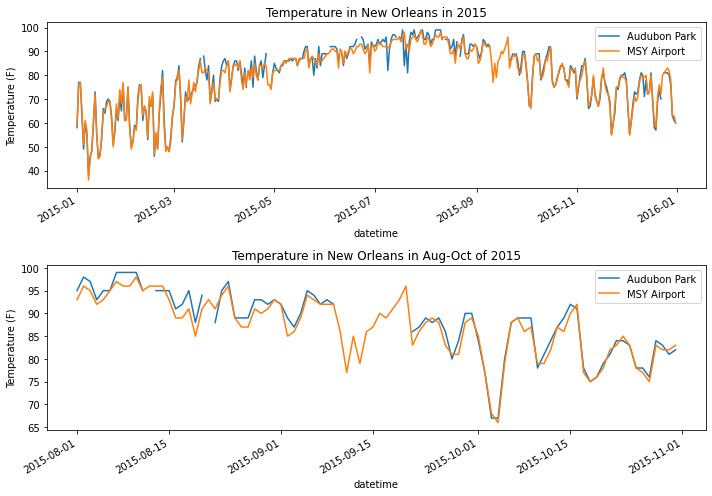

In [26]:
fig,axes=plt.subplots(nrows=2,figsize=(10,7))
ax=axes[0]
(audubon['TMAX'].loc[str(year)+'-01-01':str(year)+'-12-31']-1).plot(ax=ax,label='Audubon Park')
(airport['TMAX'].loc[str(year)+'-01-01':str(year)+'-12-31']).plot(ax=ax,label='MSY Airport')
ax.legend()
ax.set_title('Temperature in New Orleans in '+str(year))
ax.set_ylabel('Temperature (F)')

ax=axes[1]
(audubon['TMAX'].loc[str(year)+'-08-01':str(year)+'-10-31']-1).plot(ax=axes[1],label='Audubon Park')
(airport['TMAX'].loc[str(year)+'-08-01':str(year)+'-10-31']).plot(ax=axes[1],label='MSY Airport')
axes[1].legend()
ax.set_title('Temperature in New Orleans in Aug-Oct of '+str(year))
ax.set_ylabel('Temperature (F)')

plt.tight_layout()

Temperatures at Audubon were found to be 1 degree F warmer than MSY on average. This is because Audubon Park is located in the city center, and heat pools in the urban areas of cities. Therefore, 1 degree F is subtracted from the Audubon record before they are averaged

In [20]:
stack=airport.copy()
stack=stack.drop(['STATION','NAME','DATE'],axis=1)
stack=stack.rename(columns={'TMAX':'AUD_TMAX','TMIN':'AUD_TMIN','TAVG':'AUD_TAVG'})
stack[['AUD_TMAX','AUD_TMIN','AUD_TAVG']]=stack[['AUD_TMAX','AUD_TMIN','AUD_TAVG']]-1
stack[['MSY_TMAX','MSY_TMIN','MSY_TAVG']]=audubon.reindex(stack.index)[['TMAX','TMIN','TOBS']]
stack['TMAX_STACK']=stack[['MSY_TMAX','AUD_TMAX']].mean(axis=1)
stack['TMIN_STACK']=stack[['MSY_TMIN','AUD_TMIN']].mean(axis=1)
stack['TAVG_STACK']=stack[['TMAX_STACK','TMIN_STACK']].mean(axis=1)

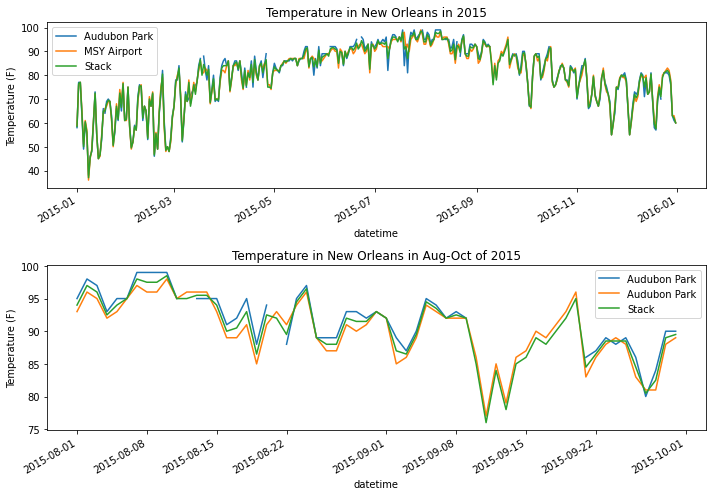

In [27]:
fig,axes=plt.subplots(nrows=2,figsize=(10,7))
(audubon['TMAX'].loc[str(year)+'-01-01':str(year)+'-12-31']-1).plot(ax=axes[0],label='Audubon Park')
airport['TMAX'].loc[str(year)+'-01-01':str(year)+'-12-31'].plot(ax=axes[0],label='MSY Airport')
stack['TMAX_STACK'].loc[str(year)+'-01-01':str(year)+'-12-31'].plot(ax=axes[0],label='Stack')
axes[0].legend()
axes[0].set_title('Temperature in New Orleans in '+str(year))
axes[0].set_ylabel('Temperature (F)')

(audubon['TMAX'].loc[str(year)+'-08-01':str(year)+'-09-30']-1).plot(ax=axes[1],label='Audubon Park')
airport['TMAX'].loc[str(year)+'-08-01':str(year)+'-09-30'].plot(ax=axes[1],label='Audubon Park')
stack['TMAX_STACK'].loc[str(year)+'-08-01':str(year)+'-09-30'].plot(ax=axes[1],label='Stack')
axes[1].legend()
axes[1].set_title('Temperature in New Orleans in Aug-Oct of '+str(year))
axes[1].set_ylabel('Temperature (F)')

plt.tight_layout()

### Pivot index to day of the year
Right now, the data has many thousands of rows, where each row is a day that has temperature values over the course of many years. I would like the table to have only 365 rows, and the years as columns. We also arrange the data to start in August, so winter appears in the middle of the plot.

In [45]:
stack.head()

,AUD_TAVG,AUD_TMAX,AUD_TMIN,Year,Month,Day,MSY_TMAX,MSY_TMIN,MSY_TAVG,TMAX_STACK,TMIN_STACK,TAVG_STACK,Month-Day
datetime,,,,,,,,,,,,,
1946-01-01,50.0,NaN,NaN,1946,1,1,NaN,NaN,NaN,NaN,NaN,NaN,01-01
1946-01-02,51.0,NaN,NaN,1946,1,2,65.0,36.0,61.0,65.0,36.0,50.5,01-02
1946-01-03,58.0,NaN,NaN,1946,1,3,73.0,48.0,67.0,73.0,48.0,60.5,01-03
1946-01-04,60.0,NaN,NaN,1946,1,4,72.0,53.0,67.0,72.0,53.0,62.5,01-04
1946-01-05,64.0,NaN,NaN,1946,1,5,71.0,57.0,64.0,71.0,57.0,64.0,01-05


In [29]:
start_daynum=213

In [30]:
stack['Month-Day']=(stack['Month'].astype(str).str.zfill(2)+'-'+stack['Day'].astype(str).str.zfill(2))    
stack_noleap=stack[stack['Month-Day']!='02-29'].copy().loc['1960':]
cycle=np.arange(365-start_daynum+1,365).tolist()+np.arange(0,365-start_daynum+1).tolist()
cyclecolumn=cycle*(stack.Year.max()-stack.Year.min()+1)
cyclecolumn=cyclecolumn[:len(stack_noleap)]
stack_noleap['#nCycle']=cyclecolumn

In [86]:
historical=stack_noleap.pivot(index=['#nCycle','Month-Day'],
                              columns='Year',values='TMAX_STACK').reset_index(level=0).iloc[:,1:]

### Visualize
Below you can see the shape of the data. Each year stacked on top of the year before it. Older years have bluer colors, more recent years have yellower colors. 

In [87]:
start_year=1960

In [88]:
daterangemin=start_year
daterangemax=2021
nyears=daterangemax-daterangemin

In [89]:
all_colors=sns.color_palette('viridis',nyears)

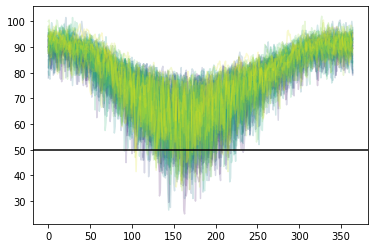

In [90]:
fig,ax=plt.subplots()
for i,year in enumerate(range(daterangemin,daterangemax)):
    historical.reset_index(level=0)[year].plot(ax=ax,color=all_colors[i],alpha=.2)
ax.axhline(50,color='k')

### Calculate Climatology
Weather data is very noisy. Therefore, we take the average over many years. Below, this, called the climatological means, is calculated. Climate is typically appraised over a 30 year interval. We calculate both the mean and std deviation. 

In [91]:
n=30
climatology_std=historical.rolling(n,axis=1,min_periods=n-1).std().iloc[:,n::n]
climatology_mean=historical.rolling(n,axis=1,min_periods=n-1).mean().iloc[:,n::n]

In [93]:
historical_colors=sns.color_palette('viridis',climatology_mean.shape[1])

In [94]:
historical_colors

[(0.190631, 0.407061, 0.556089), (0.20803, 0.718701, 0.472873)]

In [95]:
from matplotlib.patches import Rectangle

In [96]:
years=climatology_mean.columns.tolist()

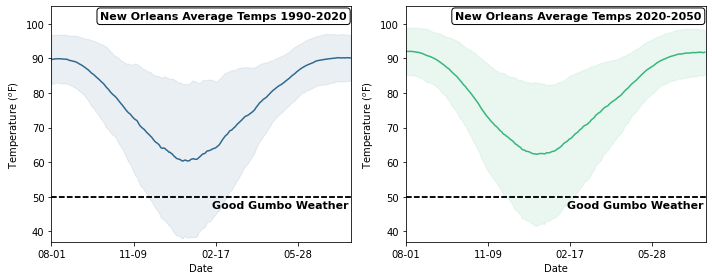

In [102]:
years=[1990,2020]
fig,axes=plt.subplots(ncols=2,figsize=(10,4))
for i,ax in enumerate(axes):
    ser=climatology_mean[years[i]].rolling(30,center=True,min_periods=15).mean()
    std_ser=climatology_std[years[i]].rolling(30,center=True,min_periods=15).mean()
    
    ser.plot(ax=ax,color=historical_colors[i])
    ax.fill_between(x=climatology_mean.index,
                    y1=ser-2*std_ser,
                    y2=ser+2*std_ser,
                    color=historical_colors[i],alpha=.1)
    
    xmax=len(climatology_mean)
    ymax=105
    ymin=37
    ax.axhline(50,color='k',ls='--')
    ax.set_xlim(0,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature ($^o$F)')
    ax.axhline(50,color='k',ls='--')
    
    ax.annotate('Good Gumbo Weather',xy=(xmax-3,49),
                ha='right',va='top',fontweight='bold',fontsize=11)
    
    ax.annotate('New Orleans Average Temps '+str(years[i])+'-'+str(years[i]+30),xy=(xmax-5,ymax-1.4),
            ha='right',va='top',fontsize=11,fontweight='bold',
            bbox=dict(boxstyle='round',fc='w',ec='k'));
plt.tight_layout()

## Climate Projections
This portion of the code uses the data for climate projections drawn down using the Access CMIP6 notebook.

In [105]:
proj_path='/Users/danielbabin/GitHub/LouisianaWinters/Data/SSPs/'

In [106]:
files=os.listdir(proj_path)
files.sort()
files=files[1:]
handles=[file[:-4] for file in files]

Here you can select which scenario we use. We advance using the 'ssp245' tag, which represents [Relative Concentration Pathway 4.5](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway), a moderate CO2 emissions scenario.

In [107]:
chosen_tables=['historical','ssp245']

### Import, Reshaping, Convert, Model Stats
The code below functions similar to the code we applied to the historical data. It groups the projections into two different intervals. One between 2020-2050, and another between 2050-2080. For each of these intervals, it reshapes that data Into a table with 365 rows, one for each day of the year, and columns for each year. This operation is slightly more complicated because there are many different simulations for each year, each representing differnt climate models, which will have slightly different physics. 

In [108]:
chosen_projections=['historical','ssp245 20-50','ssp245 50-80']
slice_years={'ssp245 20-50':['2020','2050'],
             'ssp245 50-80':['2050','2080']}

In [109]:
tables={}
projections={}
model_list={}
projs_means={}
projs_stds={}

for tablename in chosen_tables:
    tables[tablename]=pd.read_csv(proj_path+tablename+'.csv')
    tables[tablename]['datetime']=pd.to_datetime(tables[tablename]['date'])
    tables[tablename].set_index('datetime',inplace=True)

for handle in chosen_projections:
    if handle=='historical':
        projections[handle]=tables[handle].copy()
        model_list[handle]=projections[handle].columns[4:].to_list()
        nyears=30
    else:
        if handle=='ssp245 20-50':
            projections[handle]=tables[handle[:6]].loc[slice_years[handle][0]:slice_years[handle][1]].copy()
        elif handle=='ssp245 50-80':
            projections[handle]=tables[handle[:6]].loc[slice_years[handle][0]:slice_years[handle][1]].copy()
        model_list[handle]=projections[handle].columns[5:].to_list()
        nyears=31
    
    ### date
    projections[handle]['Year']=projections[handle].index.year
    projections[handle]['Month']=projections[handle].index.month
    projections[handle]['Day']=projections[handle].index.day
    projections[handle]['Month-Day']=(projections[handle]['Month'].astype(str).str.zfill(2)+'-'+
                                      projections[handle]['Day'].astype(str).str.zfill(2))
    
    cycle=np.arange(365-start_daynum+1,365).tolist()+np.arange(0,365-start_daynum+1).tolist()
    projections[handle]['#nCycle']=cycle*nyears
    
    ### reshape
    projections[handle]=projections[handle].pivot(index=['#nCycle','Month-Day'],columns='Year',
                                                  values=model_list[handle])
    
    ###
    projs_means[handle]=pd.DataFrame(index=projections[handle].index)
    projs_stds[handle]=pd.DataFrame(index=projections[handle].index)
    for model in model_list[handle]:
        projs_stds[handle][model]=(projections[handle][model].std(axis=1)*9/5)
        projs_means[handle][model]=(projections[handle][model].mean(axis=1)-273)*9/5+32

### Anomaly with 1985-2014
It is best to compare each models output temperature for a year in the future to the same model's output for a day in the past, and add that temperature difference to a real, measured historical temperature, rather than take the output of the model directly. This is a common procedure for climate models.  
  
The "historical" simulations for these climate models end at 2015, so we take that climatology (1985-2015) from the models, and compare it to the climatology from that same time interval in the historical data.

In [110]:
historical_anomalies={}
for handle in chosen_projections[1:]:
    historical_anomalies[handle]=pd.DataFrame(index=projs_means[handle].index)
    for model in model_list[handle]:
        if model in model_list['historical']:
            historical_anomalies[handle][model]=projs_means[handle][model]-projs_means['historical'][model]

In [113]:
data1984to2014=historical.iloc[:,31:-6].mean(axis=1)
data1984to2014sm=data1984to2014.rolling(30,center=True,min_periods=15).mean()

In [114]:
final_projs={}
for handle in chosen_projections[1:]:
    final_projs[handle]=pd.DataFrame(index=projs_means[handle].index.get_level_values(1))
    for model in historical_anomalies[handle].columns:
            final_projs[handle][model]=data1984to2014sm+historical_anomalies[handle].reset_index(level=0)[model]

### Ensemble
Climate models are typically appraised in an ensemble. This means you look at a group of models and calculate a sort of average behavior. It's best to calculate a sort of weighted mean, where the weight for each model comes from how well this model performed in simulating past climate variability. The source for this method is [Brunner et al., 2020](https://esd.copernicus.org/articles/11/995/2020/). This approach actually reduces the projected warming rather than accentuating it. 

In [115]:
weights={'ACCESS-CM2':0.0499,'ACCESS-ESM1-5':0.0358,'AWI-CM-1-1-MR':0.0436,'BCC-CSM2-MR':0.0354,
         'CanESM5':0.0013,'EC-Earth3-Veg':0.0092,'EC-Earth3':0.0079,'FGOALS-g3':0.0069,'GFDL-ESM4':0.1287,
         'INM-CM4-8':0.0142,'INM-CM5-0':0.0430,'IPSL-CM6A-LR':0.0224,'MIROC6':0.0378,'MPI-ESM1-2-HR':0.0524,
         'MPI-ESM1-2-LR':0.0401,'MRI-ESM2-0':0.0189,'NESM3':0.0072,'NorESM2-MM':0.0223}

In [116]:
weighted_means={}
weighted_stds={}
ensemble={}
for handle in chosen_projections[1:]:
    weighted_means[handle]=pd.DataFrame(index=final_projs[handle].index)
    weighted_stds[handle]=pd.DataFrame(index=final_projs[handle].index)
    ensemble[handle]=pd.DataFrame(index=final_projs[handle].index)
    
    models_sum=[]
    for col in final_projs[handle].columns:
        if col in weights.keys():
            models_sum.append(weights[col])
            factor=1/sum(models_sum)
            weighted_means[handle][col]=final_projs[handle][col]*weights[col]
            weighted_stds[handle][col]=(projs_stds[handle].reset_index(level=0)[col]*weights[col])
            
            ensemble[handle]['mean']=weighted_means[handle].sum(axis=1)*factor
            ensemble[handle]['std']=weighted_stds[handle].sum(axis=1)*factor

### Visualize

In [117]:
projection_colors=sns.color_palette('plasma',2)

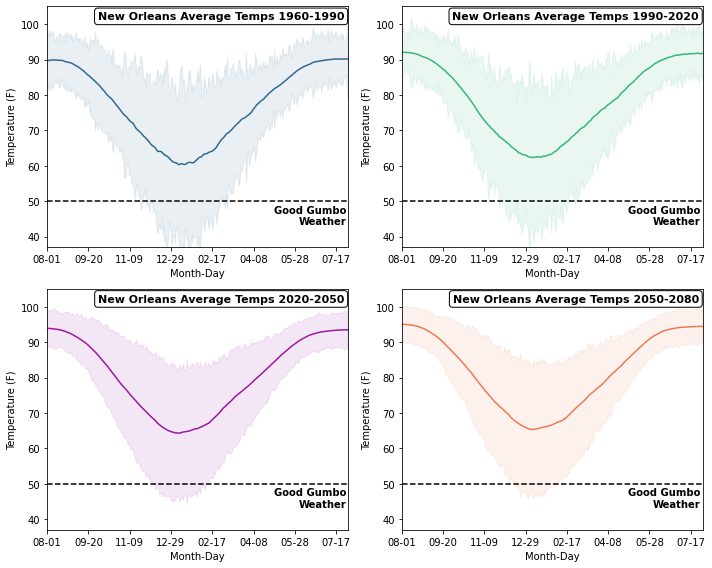

In [134]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
plt.subplots_adjust(left=.09,right=.98,top=.98)

ax=axes[0,0]
year=1990
ser=climatology_mean[year].rolling(30,center=True,min_periods=15).mean()
ser.plot(ax=ax,color=historical_colors[0])
ax.fill_between(x=climatology_mean.index,
                y1=ser-2*climatology_std[year],
                y2=ser+2*climatology_std[year],
                color=historical_colors[0],alpha=.1)

ax=axes[0,1]
year=2020
ser=climatology_mean[year].rolling(30,center=True,min_periods=15).mean()
ser.plot(ax=ax,color=historical_colors[1])
ax.fill_between(x=climatology_mean.index,
                y1=ser-2*climatology_std[year],
                y2=ser+2*climatology_std[year],
                color=historical_colors[1],alpha=.1)

axlist=[[1,0],[1,1]]
for i,proj in enumerate(['ssp245 20-50','ssp245 50-80']):
    ax=axes[1,i]
    ser=ensemble[proj]['mean'].rolling(30,center=True,min_periods=15).mean()
    ser.plot(ax=ax,color=projection_colors[i])
    ax.fill_between(x=ser.index,
                    y1=ser+2*ensemble[proj]['std'],
                    y2=ser-2*ensemble[proj]['std'],
                    color=projection_colors[i],alpha=.1)


### y stuff
ymax=105
ymin=37
xmax=len(climatology_mean)
yearlist=['1960-1990','1990-2020','2020-2050','2050-2080']
i=0
for ax in axes:
    for subax in ax:
        subax.set_ylim(ymin,ymax)
        subax.set_xlim(0,xmax)
        subax.axhline(50,color='k',ls='--')
        subax.annotate('Good Gumbo\nWeather',xy=(len(climatology_mean)-3,49),
                    ha='right',va='top',fontweight='bold',fontsize=10)
        subax.set_ylabel('Temperature (F)')
        subax.annotate('New Orleans Average Temps '+yearlist[i],xy=(xmax-5,ymax-1.4),
            ha='right',va='top',fontsize=11,fontweight='bold',
            bbox=dict(boxstyle='round',fc='w',ec='k'));
        i+=1
        
plt.tight_layout()

In [951]:
projections_animation_path='/Users/danielbabin/GitHub/LouisianaWinters/Graphics/FramesProjections/'

### Historical Frames

In [993]:
dpi=100
for i,year in enumerate(years):
    for j in climatology_mean.reset_index(level=0).index[::3]:
        clear_output(wait=True)
        data=climatology_mean.reset_index(level=0).rolling(30,center=True,min_periods=15).mean()[year].loc[:j]
        uncertainty=climatology_std.reset_index(level=0)[year].loc[:j]

        fig,ax=plt.subplots(facecolor='w')
        plt.subplots_adjust(left=.1,right=.98,top=.98)
        
        if i == 1:
            climatology_mean[1990].rolling(30,center=True,min_periods=15).mean().plot(ax=ax,
                                                                                      color=decadal_colors[0],
                                                                                      alpha=.33)
            
        data.plot(ax=ax,color=decadal_colors[i])
        ax.fill_between(x=data.index,y1=data-2*uncertainty,
                        y2=data+2*uncertainty,color=decadal_colors[i],alpha=.2)

        ### y stuff
        ax.axhline(50,color='k',ls='--')
        ax.annotate('Good Gumbo Weather',xy=(len(climatology_mean)-3,49),
                    ha='right',va='top',fontweight='bold',fontsize=11)
        
        ax.set_ylabel('Daily Maximum Temperature (F)',fontweight='bold')
        ax.set_xlabel('Date',fontweight='bold')
        
        ymax=110
        ymin=32
        xmax=len(climatology_mean)
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(0,xmax)
        ax.set_xticks(np.linspace(0,302,7,dtype=int))
        ax.set_xticklabels(['08-14','10-03','11-22','01-11','03-02','04-21','06-10'])

        ax.annotate('New Orleans Average Temps '+str(int(year)-30)+'-'+str(year),xy=(xmax-5,ymax-1.4),
                    ha='right',va='top',fontsize=13,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'))
        
        ax.annotate('Historical: '+str(year),xy=(xmax-5,ymin+1.4),
                    ha='right',va='bottom',fontsize=11,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));
        
        ### Gumbo weather details
        if j=='06-30':  
            for m in range(60):
                if (j[:2]=='08')|(j[:2]=='09')|(j[:2]=='10')|(j[:2]=='11')|(j[:2]=='12'):
                    fig.savefig(projections_animation_path+
                                str(year)+'-'+str(j)+'-pause-'+str(m).zfill(2)+'.png',dpi=dpi)            
                    plt.close()
                else:
                    fig.savefig(projections_animation_path+
                                str(int(year)+1)+'-'+str(j)+'-pause-'+str(m).zfill(2)+'.png',dpi=dpi)            
                    plt.close()
                    
        else:

            if (j[:2]=='08')|(j[:2]=='09')|(j[:2]=='10')|(j[:2]=='11')|(j[:2]=='12'):
                fig.savefig(projections_animation_path+str(year)+'-'+str(j)+'.png',
                            dpi=dpi)            
                plt.close()
            else:
                fig.savefig(projections_animation_path+str(int(year)+1)+'-'+str(j)+'.png',
                            dpi=dpi)            
                plt.close()
                
        print(str(year)+'-'+j)

2020-06-30


### Projection Frames

In [994]:
co2_concs=['440','550','1000']

In [995]:
dpi=100
year=2100
for i,proj in enumerate(['ssp126','ssp245','ssp585']):
    for j in ensemble[proj]['mean'].index[::3]:
        clear_output(wait=True)
        data=ensemble[proj]['mean'].rolling(30,center=True,min_periods=15).mean().loc[:j]
        m_uncertainty=ensemble[proj]['std'].loc[:j]

        fig,ax=plt.subplots(facecolor='w')
        plt.subplots_adjust(left=.1,right=.98,top=.98)
        
        if i == 0:
            df=climatology_mean.reset_index(level=0)
            df.rolling(30,center=True,min_periods=15).mean()[1990].plot(ax=ax,color=decadal_colors[0],alpha=.33)
            df.rolling(30,center=True,min_periods=15).mean()[2020].plot(ax=ax,color=decadal_colors[1],alpha=.33)
        if i == 1:
            df=climatology_mean.reset_index(level=0)
            df.rolling(30,center=True,min_periods=15).mean()[1990].plot(ax=ax,color=decadal_colors[0],alpha=.33)
            df.rolling(30,center=True,min_periods=15).mean()[2020].plot(ax=ax,color=decadal_colors[1],alpha=.33)
            ensemble['ssp126']['mean'].rolling(30,center=True,
                                               min_periods=15).mean().plot(ax=ax,color=projection_colors[0],
                                                                           alpha=.33)
        if i == 2:
            df=climatology_mean.reset_index(level=0)
            df.rolling(30,center=True,min_periods=15).mean()[1990].plot(ax=ax,color=decadal_colors[0],alpha=.33)
            df.rolling(30,center=True,min_periods=15).mean()[2020].plot(ax=ax,color=decadal_colors[1],alpha=.33)
            ensemble['ssp126']['mean'].rolling(30,center=True,
                                               min_periods=15).mean().plot(ax=ax,color=projection_colors[0],
                                                                           alpha=.33)
            ensemble['ssp245']['mean'].rolling(30,center=True,
                                               min_periods=15).mean().plot(ax=ax,color=projection_colors[1],
                                                                           alpha=.33)
            
        data.plot(ax=ax,color=projection_colors[i])
        ax.fill_between(x=data.index,y1=data-2*m_uncertainty,y2=data+2*m_uncertainty,
                        color=projection_colors[i],alpha=.15)
        
        ### y stuff
        ax.axhline(50,color='k',ls='--')
        ax.annotate('Good Gumbo Weather',xy=(len(ensemble[proj])-3,49),
                    ha='right',va='top',fontweight='bold',fontsize=11)
        ax.set_ylabel('Daily Maximum Temperature (F)',fontweight='bold')
        
        ### x management
        ymax=110
        ymin=32
        xmax=len(ensemble[proj])
        ax.set_xlabel('Date',fontweight='bold')
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(0,xmax)
        ax.set_xticks(np.linspace(0,302,7,dtype=int))
        ax.set_xticklabels(['08-14','10-03','11-22','01-11','03-02','04-21','06-10'])
        
        ### annotations from other chart
        ax.annotate('New Orleans Average Temps 2070-2100',xy=(xmax-5,ymax-1.4),
                    ha='right',va='top',fontsize=13,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));
        
        ax.annotate('Projection: CO$_2$ @ '+co2_concs[i]+' ppm',xy=(xmax-5,ymin+1.4),
                    ha='right',va='bottom',fontsize=11,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));
        
        ### Gumbo weather details
        y_start=71
        if j=='06-30':  
            for m in range(100):
                if (j[:2]=='08')|(j[:2]=='09')|(j[:2]=='10')|(j[:2]=='11')|(j[:2]=='12'):
                    fig.savefig(projections_animation_path+proj+'-'+
                                str(year)+'-'+str(j)+'-pause-'+str(m).zfill(2)+'.png',dpi=dpi)            
                    plt.close()
                else:
                    fig.savefig(projections_animation_path+proj+'-'+
                                str(int(year)+1)+'-'+str(j)+'-pause-'+str(m).zfill(2)+'.png',dpi=dpi)            
                    plt.close()
                    
        else:
            if (j[:2]=='08')|(j[:2]=='09')|(j[:2]=='10')|(j[:2]=='11')|(j[:2]=='12'):
                fig.savefig(projections_animation_path+proj+'-'+str(year)+'-'+str(j)+'.png',dpi=dpi)            
                plt.close()
            else:
                fig.savefig(projections_animation_path+proj+'-'+str(int(year)+1)+'-'+str(j)+'.png',dpi=dpi)            
                plt.close()
                
        print(proj+'-'+j)

ssp585-06-30


In [996]:
animation_path_files=projections_animation_path+'*.png'

In [997]:
import glob
from PIL import Image

img, *imgs = [Image.open(f) for f in sorted(glob.glob(animation_path_files))]
img.save(fp=out_path+'gumboWeatherProjections.gif', format='GIF', append_images=imgs,
         save_all=True, duration=20, loop=0)

## Export

In [137]:
temperature_data=pd.DataFrame(index=climatology_mean.index)
for year in [1990,2020]:
    dfdata=climatology_mean[year]
    text=str(year-30)+'-'+str(year)
    temperature_data[text+' Temperature (F)']=dfdata
    temperature_data[text+' Smooth Temperature (F)']=dfdata.rolling(30,center=True,min_periods=15).mean()
    dfstd=climatology_std[year]
    temperature_data[text+' 1 Std Dev (F)']=dfstd
    temperature_data[text+' Smooth 1 Std Dev (F)']=dfstd.rolling(30,center=True,min_periods=15).mean()
proj_years=[2050,2080]
for i,proj in enumerate(chosen_projections[1:]):
    df=ensemble[proj].copy()
    text=str(proj_years[i]-30)+'-'+str(proj_years[i])
    df=df.rename(columns={'mean':text+' Temperature (F)',
                          'std':text+' 1 Std Dev (F)'})
    temperature_data=pd.concat([temperature_data,df],axis=1)

In [139]:
temperature_data.to_csv(table_path+'NewOrleansTemperatures.csv')

# Probability

In [140]:
stdnorms=(pd.read_csv(data_path+'standard_normals.csv').iloc[:,1:].values)
stdnorms=stdnorms.reshape(stdnorms.shape[0]*stdnorms.shape[1])
f=interpolate.interp1d(np.arange(0,4.1,.01),stdnorms,bounds_error=False)
stdnorms=pd.DataFrame(index=np.arange(0,4.1,.001),columns=['%'])
stdnorms['%']=f(stdnorms.index)
stdnorms=stdnorms.dropna()

In [141]:
threshold1=50
threshold2=80

In [142]:
probability={}
dfmean=climatology_mean.rolling(30,center=True,min_periods=15).mean()
dfstd=climatology_std
for year in [1990,2020]:
    probability[year]=pd.DataFrame(index=dfmean.index)
    probability[year]['diff1']=((dfmean[year]-threshold1)/dfstd[year]).rolling(30,center=True,
                                                                               min_periods=15).mean().round(2)
    probability[year]['diff2']=((threshold2-dfmean[year])/dfstd[year]).rolling(30,center=True,
                                                                               min_periods=15).mean().round(2)
    probability[year]['%<t1']=np.nan
    probability[year]['%<t2']=np.nan
    for i in probability[year].index:
        val1=probability[year].loc[i,'diff1']
        val2=probability[year].loc[i,'diff2']
        if (val1<4.1)&(val1>0):
            probability[year].loc[i,'%<t1']=(1-stdnorms.loc[val1:val1+.0009,'%'].values[0])*100
            
        if (val2<4.1)&(val2>0):
            probability[year].loc[i,'%<t2']=(1-stdnorms.loc[val2:val2+.0009,'%'].values[0])*100
            
for handle in chosen_projections[1:]:
    probability[handle]=pd.DataFrame(index=ensemble[handle].index)
    probability[handle]['diff1']=((ensemble[handle]['mean']-
                                   threshold1)/ensemble[handle]['std']).rolling(30,center=True,
                                                                               min_periods=15).mean().round(2)
    probability[handle]['diff2']=((threshold2-ensemble[handle]['mean'])/
                                  ensemble[handle]['std']).rolling(30,center=True,
                                                                               min_periods=15).mean().round(2)
    probability[handle]['%<t1']=np.nan
    probability[handle]['%<t2']=np.nan
    for i in probability[handle].index:
        val1=probability[handle].loc[i,'diff1']
        val2=probability[handle].loc[i,'diff2']
        if (val1<4.1)&(val1>0):
            probability[handle].loc[i,'%<t1']=(1-stdnorms.loc[val1:val1+.0009,'%'].values[0])*100
        
        if (val2<4.1)&(val2>0):
            probability[handle].loc[i,'%<t2']=(1-stdnorms.loc[val2:val2+.0009,'%'].values[0])*100

In [143]:
smooth_probability={}
for key in probability.keys():
    smooth_probability[key]=probability[key].rolling(30,center=True,min_periods=15).mean()

## Visualize

In [144]:
scenarios=['Historical: 1960-1990','Historical: 1990-2020',
           'Projection: 2020-2050','Projection: 2050-2080']

In [145]:
graphics_path='/Users/danielbabin/GitHub/GumboWeather/Graphics/'

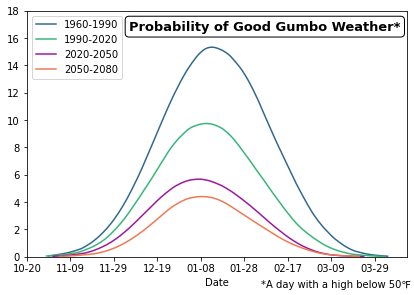

In [147]:
kind='%<t1'
fig,ax=plt.subplots(facecolor='w')
plt.subplots_adjust(left=.1,right=.98,top=.98)
smooth_probability[1990][kind].plot(color=historical_colors[0],ax=ax,label='1960-1990')
smooth_probability[2020][kind].plot(color=historical_colors[1],ax=ax,label='1990-2020')
smooth_probability['ssp245 20-50'][kind].plot(color=projection_colors[0],ax=ax,label='2020-2050')
smooth_probability['ssp245 50-80'][kind].plot(color=projection_colors[1],ax=ax,label='2050-2080')

ymax=18
ymin=0
xmin=80
xmax=255
ax.set_xlabel('Date')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)

# ax.set_xticks(np.linspace(80,250,8,dtype=int))
# ax.set_xticklabels(['11-01','11-21','12-11','12-31','01-20','02-09','03-01','03-21']);

ax.annotate('Probability of Good Gumbo Weather*',xy=(xmax-3,ymax-.7),
                    ha='right',va='top',fontsize=13,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));
      
# ax.annotate(scenarios[3],xy=(xmax-3,ymax-2.5),
#             ha='right',va='top',fontsize=11,fontweight='bold',
#             bbox=dict(boxstyle='round',fc='w',ec='k'));

ax.legend(loc='upper left')

ax.annotate('*A day with a high below 50℉',xy=(.95,.02),xycoords='figure fraction',ha='right',va='bottom')
fig.savefig(graphics_path+'GumboWeatherProbabilityStill.png',dpi=100)

In [149]:
colors=historical_colors+projection_colors

## Animate

In [150]:
probability_animation_path='/Users/danielbabin/GitHub/LouisianaWinters/Graphics/GumboWeather/FramesProbability/'

In [923]:
dpi=100
for i,key in enumerate(smooth_probability.keys()):
    for j in smooth_probability[key]['%<t1'].index[::3]:
        clear_output(wait=True)
        data=smooth_probability[key]['%<t1'].loc[:j]

        fig,ax=plt.subplots(facecolor='w')
        plt.subplots_adjust(left=.1,right=.98,top=.98)
        if i == 0:
            year=1990
        if i == 1:
            year=2020
            smooth_probability[1990]['%<t1'].plot(ax=ax,color=decadal_colors[0],alpha=.33)
        if i == 2:
            year=2070
            smooth_probability[1990]['%<t1'].plot(ax=ax,color=decadal_colors[0],alpha=.33)
            smooth_probability[2020]['%<t1'].plot(ax=ax,color=decadal_colors[1],alpha=.33)
        if i == 3:
            year=2070
            smooth_probability[1990]['%<t1'].plot(ax=ax,color=decadal_colors[0],alpha=.33)
            smooth_probability[2020]['%<t1'].plot(ax=ax,color=decadal_colors[1],alpha=.33)
            smooth_probability['ssp126']['%<t1'].plot(ax=ax,color=projection_colors[0],alpha=.33)
        if i == 4:
            year=2070
            smooth_probability[1990]['%<t1'].plot(ax=ax,color=decadal_colors[0],alpha=.33)
            smooth_probability[2020]['%<t1'].plot(ax=ax,color=decadal_colors[1],alpha=.33)
            smooth_probability['ssp126']['%<t1'].plot(ax=ax,color=projection_colors[0],alpha=.33)
            smooth_probability['ssp245']['%<t1'].plot(ax=ax,color=projection_colors[1],alpha=.33)
            
        data.plot(ax=ax,color=colors[i])
        
        ### y stuff
        ax.set_ylabel('Probability [%]',fontweight='bold')
        
        ### x management
        ymax=18
        ymin=0
        xmin=80
        xmax=225
        ax.set_xlabel('Date',fontweight='bold')
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(xmin,xmax)
        
        ax.set_xticks(np.linspace(80,221,8,dtype=int))
        ax.set_xticklabels(['11-01','11-21','12-11','12-31','01-20','02-09','03-01','03-21']);

        ax.annotate('Probability of Good Gumbo Weather',xy=(xmax-3,ymax-.7),
                    ha='right',va='top',fontsize=13,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));
      
        ax.annotate(scenarios[i],xy=(xmax-3,ymax-2.5),
                    ha='right',va='top',fontsize=11,fontweight='bold',
                    bbox=dict(boxstyle='round',fc='w',ec='k'));
        
        ax.annotate('*A day with a high below 50℉',xy=(.98,.015),xycoords='figure fraction',
                    ha='right',va='bottom',size=9)
            
        if j=='06-30':                    
            for m in range(100):
                if (j[:2]=='08')|(j[:2]=='09')|(j[:2]=='10')|(j[:2]=='11')|(j[:2]=='12'):
                    fig.savefig(probability_animation_path+str(key)+'-'+
                                str(year)+'-'+str(j)+'-pause-'+str(m).zfill(2)+'.png',dpi=dpi)            
                    plt.close()
                else:
                    fig.savefig(probability_animation_path+str(key)+'-'+
                                str(int(year)+1)+'-'+str(j)+'-pause-'+str(m).zfill(2)+'.png',dpi=dpi)            
                    plt.close()
                    
        else:
            if (j[:2]=='08')|(j[:2]=='09')|(j[:2]=='10')|(j[:2]=='11')|(j[:2]=='12'):
                fig.savefig(probability_animation_path+str(key)+'-'+str(year)+'-'+str(j)+'.png',dpi=dpi)            
                plt.close()
            else:
                fig.savefig(probability_animation_path+str(key)+'-'+str(int(year)+1)+'-'+str(j)+'.png',dpi=dpi)            
                plt.close()
                
        print(str(key)+'-'+j)

ssp585-06-30


In [924]:
probability_path_files=probability_animation_path+'*.png'

In [925]:
import glob
from PIL import Image

img, *imgs = [Image.open(f) for f in sorted(glob.glob(probability_path_files))]
img.save(fp=out_path+'gumboWeatherProbability.gif', format='GIF', append_images=imgs,
         save_all=True, duration=20, loop=0)

## Export

In [151]:
list_projs=[1990, 2020, 'ssp245 20-50', 'ssp245 50-80']
years_list=['1960-1990','1990-2020','2020-2050','2050-2080']

In [152]:
export_probability=pd.DataFrame(index=smooth_probability[list_projs[0]].index)
for i,key in enumerate(list_projs):
    df=smooth_probability[key][['%<t1', '%<t2']].copy()
    df=df.rename(columns={'%<t1':years_list[i]+' Probability (>50F)',
                          '%<t2':years_list[i]+' Probability (<80F)'})
    export_probability=pd.concat([export_probability,df],axis=1)

In [153]:
export_probability.to_csv(table_path+'GumboWeatherProbabilities.csv')